In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import cv2
import matplotlib.pyplot as plt

In [ ]:
from zipfile import ZipFile

file_name = "/content/drive/MyDrive/DataSets/Acute Leukemia Cancer Data/archive (2).zip"

with ZipFile(file_name, 'r') as zip:
	zip.extractall('/content/drive/MyDrive/DataSets/Acute Leukemia Cancer Data')
print('Done!')

In [ ]:
os.listdir('/content/drive/MyDrive/DataSets/Acute Leukemia Cancer Data')

['Original', 'Segmented', '.ipynb_checkpoints', 'Residual_Architecture.h5']

In [ ]:
cv2.imread('/content/drive/MyDrive/DataSets/Acute Leukemia Cancer Data/Original/Benign/WBC-Benign-001.jpg').shape

(224, 224, 3)

#Benign

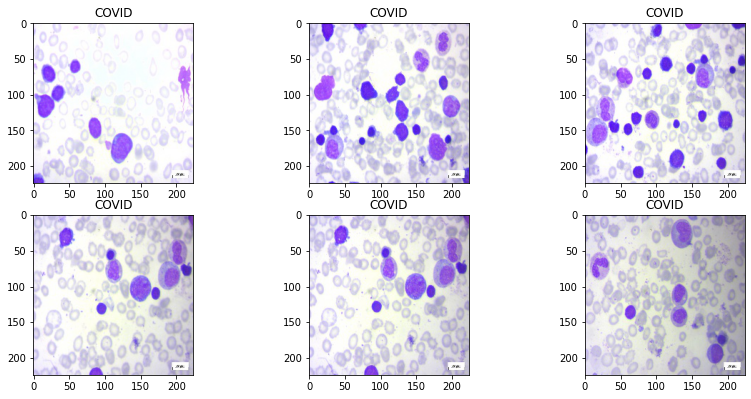

In [ ]:
from PIL import Image
way="/content/drive/MyDrive/DataSets/Acute Leukemia Cancer Data/Original/Benign"
plt.rcParams["figure.figsize"]=(14,10)
c=0
for k,i in enumerate(os.listdir(way)):
  if c==6:
    break
  plt.subplot(3,3,k+1)
  plt.imshow(Image.open(f'{way}/{i}'))
  plt.title("COVID")
  c+=1
plt.show()

# Early

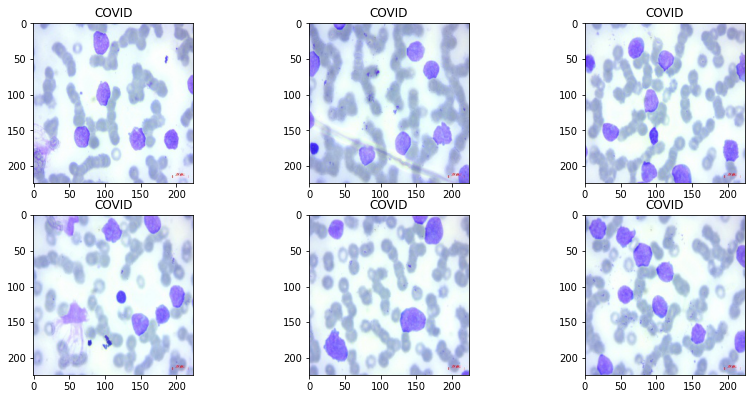

In [ ]:
from PIL import Image
way="/content/drive/MyDrive/DataSets/Acute Leukemia Cancer Data/Original/Early"
plt.rcParams["figure.figsize"]=(14,10)
c=0
for k,i in enumerate(os.listdir(way)):
  if c==6:
    break
  plt.subplot(3,3,k+1)
  plt.imshow(Image.open(f'{way}/{i}'))
  plt.title("COVID")
  c+=1
plt.show()

#PRE

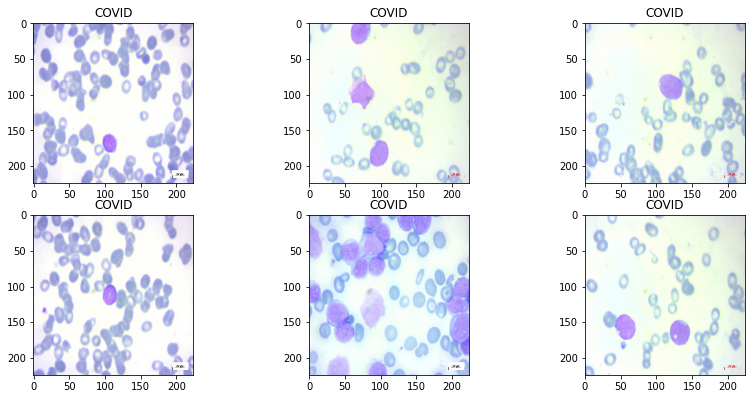

In [ ]:
from PIL import Image
way="/content/drive/MyDrive/DataSets/Acute Leukemia Cancer Data/Original/Pre"
plt.rcParams["figure.figsize"]=(14,10)
c=0
for k,i in enumerate(os.listdir(way)):
  if c==6:
    break
  plt.subplot(3,3,k+1)
  plt.imshow(Image.open(f'{way}/{i}'))
  plt.title("COVID")
  c+=1
plt.show()

#Pro

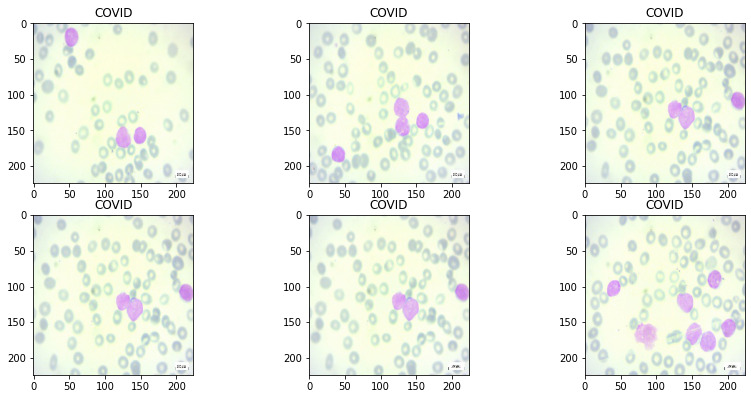

In [ ]:
from PIL import Image
way="/content/drive/MyDrive/DataSets/Acute Leukemia Cancer Data/Original/Pro"
plt.rcParams["figure.figsize"]=(14,10)
c=0
for k,i in enumerate(os.listdir(way)):
  if c==6:
    break
  plt.subplot(3,3,k+1)
  plt.imshow(Image.open(f'{way}/{i}'))
  plt.title("COVID")
  c+=1
plt.show()

In [ ]:
datagen = ImageDataGenerator(rescale=1/255.0,validation_split=0.2) 

train_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/DataSets/Acute Leukemia Cancer Data/Original',
    target_size=(128, 128),
    class_mode='sparse',
    subset='training',
    shuffle=True) 

test_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/DataSets/Acute Leukemia Cancer Data/Original', 
    target_size=(128, 128),
    class_mode='sparse',
    subset='validation',
    shuffle=True)

Found 2607 images belonging to 4 classes.
Found 649 images belonging to 4 classes.


## Visual Geometry Group Achitecture

In [ ]:
VGG19_Architecture=keras.applications.VGG16(include_top=False,
                                               weights="imagenet",
                                               input_shape=(128,128,3)
                                              )

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return lambda t: tfp.distributions.Independent(tfp.distributions.Normal(loc=tf.zeros(n, dtype=dtype),
                                                scale=1),
                                     reinterpreted_batch_ndims=1)

def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return keras.models.Sequential([
        tfp.layers.VariableLayer(tfp.layers.IndependentNormal.params_size(n), dtype=dtype),
        tfp.layers.IndependentNormal(n)
    ])

In [ ]:
def SE_BLOCK(in_block, ch, ratio=16):
    x = keras.layers.GlobalAveragePooling2D()(in_block)
    x = tfp.layers.DenseVariational(ch//ratio, posterior, prior,activation='relu',
                                    kl_weight=1/2607,
                              kl_use_exact=True)(x)
    x = tfp.layers.DenseVariational(ch, posterior, prior, 
                                    kl_weight=1/2607,activation='sigmoid',
                              kl_use_exact=True)(x)
    x = tf.reshape(x, shape=[-1, 1, 1, ch], name='scaler')
    return keras.layers.multiply([in_block, x])

In [ ]:
Exact_divergence_fn = lambda q, p, _: tfp.distributions.kl_divergence(q, 
                                                          p) / 2607
def approximate_kl(q, p, q_tensor):
    return tf.reduce_mean(q.log_prob(q_tensor) - p.log_prob(q_tensor))
Approx_divergence_fn = lambda q, p, q_tensor : approximate_kl(q, p, 
                                                      q_tensor) / 2607

In [ ]:
Input_=keras.layers.Input(shape=(128,128,3),name='inp_1')
attension_0=SE_BLOCK(Input_,3)
conv_1=keras.layers.Conv2D(16,(3,3),activation='relu',
                          )(keras.layers.concatenate([attension_0,Input_]))
Pad_1=keras.layers.AveragePooling2D((2,2))(conv_1)
attension_1=SE_BLOCK(Pad_1,16)
conv_2=keras.layers.Conv2D(32,(3,3),
                           activation='relu')(keras.layers.concatenate([attension_0,Input_]))
Pad_2=keras.layers.AveragePooling2D((2,2))(conv_2)
attension_2=SE_BLOCK(Pad_2,32)
conv_3=keras.layers.Conv2D(32,(3,3),
                           activation='relu')(keras.layers.concatenate([attension_0,Input_]))
Pad_3=keras.layers.AveragePooling2D((2,2))(conv_3)
attension_3=SE_BLOCK(Pad_3,32)
concatenate=keras.layers.concatenate([keras.layers.Flatten()(attension_1),
                                      keras.layers.Flatten()(attension_2),
                                      keras.layers.Flatten()(attension_3)
                                      ])
vgg_out=keras.layers.Flatten()(VGG19_Architecture(Input_))
Global_concatenate=keras.layers.concatenate([concatenate,vgg_out])
dense_1=keras.layers.Dense(512,activation='relu')(Global_concatenate)
dense_2=keras.layers.Dense(256,activation='relu')(dense_1)
dense_3=keras.layers.Dense(128,activation='relu')(dense_2)
dense_4=keras.layers.Dense(64,activation='relu')(dense_3)
output=keras.layers.Dense(4,activation='softmax')(dense_4)
SE_VGG_Model=keras.models.Model([Input_],[output])

In [ ]:
# plot_model(SE_VGG_Model)

In [ ]:
SE_VGG_Model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                     loss='sparse_categorical_crossentropy',
                     metrics=['Accuracy'])

In [ ]:
hist=SE_VGG_Model.fit(train_generator,epochs=22)

Epoch 1/22
82/82 [==============================] - 137s 2s/step - loss: 3.9929 - Accuracy: 0.3989
Epoch 2/22
82/82 [==============================] - 8s 100ms/step - loss: 0.9774 - Accuracy: 0.5853
Epoch 3/22
82/82 [==============================] - 8s 101ms/step - loss: 0.8016 - Accuracy: 0.6855
Epoch 4/22
82/82 [==============================] - 8s 100ms/step - loss: 0.6840 - Accuracy: 0.7254
Epoch 5/22
82/82 [==============================] - 8s 99ms/step - loss: 0.7908 - Accuracy: 0.7173
Epoch 6/22
82/82 [==============================] - 10s 126ms/step - loss: 0.6958 - Accuracy: 0.7146
Epoch 7/22
82/82 [==============================] - 10s 118ms/step - loss: 0.4760 - Accuracy: 0.7979
Epoch 8/22
82/82 [==============================] - 12s 152ms/step - loss: 0.4972 - Accuracy: 0.7940
Epoch 9/22
82/82 [==============================] - 13s 164ms/step - loss: 0.5459 - Accuracy: 0.7806
Epoch 10/22
82/82 [==============================] - 12s 141ms/step - loss: 0.4581 - Accuracy: 0.8

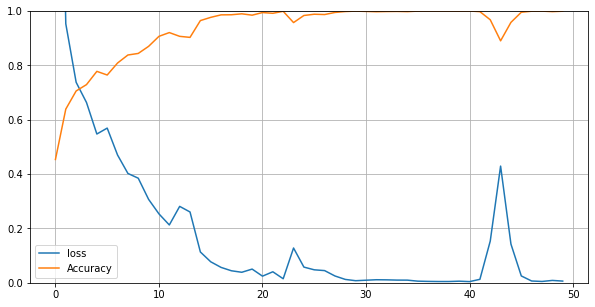

In [ ]:
plt.rcParams['figure.figsize']=(10,5)
pd.DataFrame(hist.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
SE_VGG_Model.evaluate(test_generator)

21/21 [==============================] - 47s 2s/step - loss: 1.7088 - Accuracy: 0.6348


[1.708848237991333, 0.6348227858543396]

## Model 2

In [ ]:
Input_=keras.layers.Input(shape=(128,128,3),name='inp_1')
attension_0=SE_BLOCK(Input_,3)

conv_1=keras.layers.Conv2D(32,(3,3),activation='relu',
                          )(keras.layers.concatenate([attension_0,Input_]))
Pad_1=keras.layers.AveragePooling2D((2,2))(conv_1)

con_1_2=keras.layers.Conv2D(16,(3,3),activation='relu')(Pad_1)
con_1_3=keras.layers.Conv2D(32,(3,3),activation='relu')(con_1_2)
Pad_1_=keras.layers.AveragePooling2D((2,2))(con_1_3)
attension_1=SE_BLOCK(Pad_1_,32)

conv_2=keras.layers.Conv2D(32,(3,3),
                           activation='relu')(keras.layers.concatenate([attension_0,Input_]))
Pad_2=keras.layers.AveragePooling2D((2,2))(conv_2)
con_2_2=keras.layers.Conv2D(16,(3,3),activation='relu')(Pad_2)
con_2_3=keras.layers.Conv2D(32,(3,3),activation='relu')(con_2_2)
Pad_2_=keras.layers.AveragePooling2D((2,2))(con_2_3)
attension_2=SE_BLOCK(Pad_2_,32)

conv_3=keras.layers.Conv2D(64,(3,3),
                           activation='relu')(keras.layers.concatenate([attension_0,Input_]))
Pad_3=keras.layers.AveragePooling2D((2,2))(conv_3)
con_3_2=keras.layers.Conv2D(16,(3,3),activation='relu')(Pad_3)
con_3_3=keras.layers.Conv2D(32,(3,3),activation='relu')(con_3_2)
Pad_3_=keras.layers.AveragePooling2D((2,2))(con_3_3)
attension_3=SE_BLOCK(Pad_3_,32)

concatenate=keras.layers.concatenate([keras.layers.Flatten()(attension_1),
                                      keras.layers.Flatten()(attension_2),
                                      keras.layers.Flatten()(attension_3)
                                      ])

dense_1=keras.layers.Dense(512,activation='relu')(concatenate)
drop_1=keras.layers.Dropout(0.1)(dense_1)
batch_norm_1=keras.layers.BatchNormalization()(drop_1)
dense_2=keras.layers.Dense(256,activation='relu')(batch_norm_1)
drop_2=keras.layers.Dropout(0.1)(dense_2)
batch_norm_2=keras.layers.BatchNormalization()(drop_2)
dense_3=keras.layers.Dense(128,activation='relu')(batch_norm_2)
batch_norm_3=keras.layers.BatchNormalization()(dense_3)
dense_4=keras.layers.Dense(64,activation='relu')(batch_norm_3)
output=keras.layers.Dense(4,activation='softmax')(dense_4)
SE_VGG_Model=keras.models.Model([Input_],[output])

SE_VGG_Model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                     loss='sparse_categorical_crossentropy',
                     metrics=['Accuracy'])
hist=SE_VGG_Model.fit(train_generator,epochs=22)

Epoch 1/22
82/82 [==============================] - 13s 105ms/step - loss: 1.0785 - Accuracy: 0.5558
Epoch 2/22
82/82 [==============================] - 9s 112ms/step - loss: 0.7080 - Accuracy: 0.7411
Epoch 3/22
82/82 [==============================] - 9s 105ms/step - loss: 0.7112 - Accuracy: 0.7369
Epoch 4/22
82/82 [==============================] - 11s 132ms/step - loss: 0.7420 - Accuracy: 0.7261
Epoch 5/22
82/82 [==============================] - 9s 112ms/step - loss: 0.7046 - Accuracy: 0.7403
Epoch 6/22
82/82 [==============================] - 9s 106ms/step - loss: 0.7088 - Accuracy: 0.7399
Epoch 7/22
82/82 [==============================] - 9s 103ms/step - loss: 0.8230 - Accuracy: 0.6824
Epoch 8/22
82/82 [==============================] - 9s 115ms/step - loss: 0.9372 - Accuracy: 0.6206
Epoch 9/22
82/82 [==============================] - 13s 158ms/step - loss: 0.7265 - Accuracy: 0.7200
Epoch 10/22
82/82 [==============================] - 9s 112ms/step - loss: 0.6741 - Accuracy: 0.7

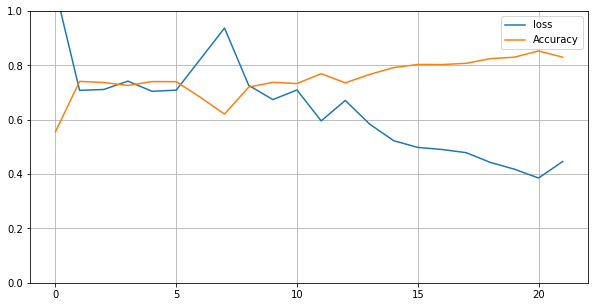

In [ ]:
plt.rcParams['figure.figsize']=(10,5)
pd.DataFrame(hist.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
SE_VGG_Model.evaluate(test_generator)

21/21 [==============================] - 4s 91ms/step - loss: 86.6277 - Accuracy: 0.2635


[86.62773132324219, 0.2634822726249695]

## Multi Output Model

In [ ]:
datagen = ImageDataGenerator(rescale=1/255.0,validation_split=0.2) 

train_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/DataSets/Acute Leukemia Cancer Data/Original',
    target_size=(128, 128),
    class_mode='categorical',
    subset='training',
    shuffle=True) 

test_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/DataSets/Acute Leukemia Cancer Data/Original', 
    target_size=(128, 128),
    class_mode='categorical',
    subset='validation',
    shuffle=True)

Found 2607 images belonging to 4 classes.
Found 649 images belonging to 4 classes.


In [ ]:
Input_=keras.layers.Input(shape=(128,128,3),name='inp_1')
attension_0=SE_BLOCK(Input_,3)

conv_1=keras.layers.Conv2D(32,(3,3),activation='relu',padding='same',
                          )(keras.layers.concatenate([attension_0,Input_]))
Pad_1=keras.layers.AveragePooling2D((2,2))(conv_1)
attension_1=SE_BLOCK(Pad_1,32)

conv_2=keras.layers.Conv2D(32,(3,3),padding='same',activation='relu')(attension_1)
Pad_2=keras.layers.AveragePooling2D((2,2))(conv_2)
attension_2=SE_BLOCK(Pad_2,32)

conv_3=keras.layers.Conv2D(32,(3,3),padding='same',activation='relu')(attension_2)
Pad_3=keras.layers.AveragePooling2D((2,2))(conv_3)
attension_3=SE_BLOCK(Pad_3,32)

concatenate=keras.layers.concatenate([keras.layers.Flatten()(attension_1),
                                      keras.layers.Flatten()(attension_2),
                                      keras.layers.Flatten()(attension_3)
                                      ])

dense_1=keras.layers.Dense(1024,activation='relu')(concatenate)
batch_norm_1=keras.layers.BatchNormalization()(dense_1)
dense_2=keras.layers.Dense(512,activation='relu')(batch_norm_1)
batch_norm_2=keras.layers.BatchNormalization()(dense_2)
dense_3=keras.layers.Dense(256,activation='relu')(batch_norm_2)
dense_4=keras.layers.Dense(128,activation='relu')(concatenate)
dense_5=keras.layers.Dense(64,activation='relu')(batch_norm_1)
output_1=keras.layers.Dense(1,activation='sigmoid')(dense_5)
output_2=keras.layers.Dense(1,activation='sigmoid')(dense_5)
output_3=keras.layers.Dense(1,activation='sigmoid')(dense_5)
output_4=keras.layers.Dense(1,activation='sigmoid')(dense_5)
SE_VGG_Model=keras.models.Model([Input_],[output_1,output_2,output_3,output_4])
SE_VGG_Model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.005),
                     loss='binary_crossentropy',
                     metrics=['Accuracy'])
hist=SE_VGG_Model.fit(train_generator,epochs=22)

In [ ]:
Input_=keras.layers.Input(shape=(128,128,3),name='inp_1')
attension_0=SE_BLOCK(Input_,3)

conv_1=keras.layers.Conv2D(32,(3,3),activation='relu',
                          )(keras.layers.concatenate([attension_0,Input_]))
Pad_1=keras.layers.AveragePooling2D((2,2))(conv_1)

con_1_2=keras.layers.Conv2D(16,(3,3),activation='relu')(Pad_1)
con_1_3=keras.layers.Conv2D(32,(3,3),activation='relu')(con_1_2)
Pad_1_=keras.layers.AveragePooling2D((2,2))(con_1_3)
attension_1=SE_BLOCK(Pad_1_,32)

conv_2=keras.layers.Conv2D(32,(3,3),
                           activation='relu')(keras.layers.concatenate([attension_0,Input_]))
Pad_2=keras.layers.AveragePooling2D((2,2))(conv_2)
con_2_2=keras.layers.Conv2D(16,(3,3),activation='relu')(Pad_2)
con_2_3=keras.layers.Conv2D(32,(3,3),activation='relu')(con_2_2)
Pad_2_=keras.layers.AveragePooling2D((2,2))(con_2_3)
attension_2=SE_BLOCK(Pad_2_,32)

conv_3=keras.layers.Conv2D(64,(3,3),
                           activation='relu')(keras.layers.concatenate([attension_0,Input_]))
Pad_3=keras.layers.AveragePooling2D((2,2))(conv_3)
con_3_2=keras.layers.Conv2D(16,(3,3),activation='relu')(Pad_3)
con_3_3=keras.layers.Conv2D(32,(3,3),activation='relu')(con_3_2)
Pad_3_=keras.layers.AveragePooling2D((2,2))(con_3_3)
attension_3=SE_BLOCK(Pad_3_,32)

concatenate=keras.layers.concatenate([keras.layers.Flatten()(attension_1),
                                      keras.layers.Flatten()(attension_2),
                                      keras.layers.Flatten()(attension_3)
                                      ])
vgg_out=keras.layers.Flatten()(VGG19_Architecture(Input_))
Global_concatenate=keras.layers.concatenate([concatenate,vgg_out])
dense_1=keras.layers.Dense(512,activation='relu')(Global_concatenate)
drop_1=keras.layers.Dropout(0.2)(dense_1)
batch_norm_1=keras.layers.BatchNormalization()(drop_1)
dense_2=keras.layers.Dense(256,activation='relu')(batch_norm_1)
drop_2=keras.layers.Dropout(0.1)(dense_2)
batch_norm_2=keras.layers.BatchNormalization()(drop_2)
dense_3=keras.layers.Dense(128,activation='relu')(batch_norm_2)
batch_norm_3=keras.layers.BatchNormalization()(dense_3)
dense_4=keras.layers.Dense(64,activation='relu')(batch_norm_3)
Dense_network=tfp.layers.DenseReparameterization(
            units=tfp.layers.OneHotCategorical.params_size(4), activation=None,
            kernel_prior_fn = tfp.layers.default_multivariate_normal_fn,
            kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(is_singular=False),
            kernel_divergence_fn = Approx_divergence_fn,
            bias_prior_fn = tfp.layers.default_multivariate_normal_fn,
            bias_posterior_fn=tfp.layers.default_mean_field_normal_fn(is_singular=False),
            bias_divergence_fn = Approx_divergence_fn)(dense_4)
inferen_output=tfp.layers.OneHotCategorical(4,name='inference_out')(Dense_network)
SE_VGG_Model=keras.models.Model([Input_],[inferen_output])

def negative_log_likelihood(y_true, y_pred):
    return -tf.reduce_sum(y_pred.log_prob(y_true))

SE_VGG_Model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
                     loss=negative_log_likelihood,
                     metrics=['Accuracy'])
hist=SE_VGG_Model.fit(train_generator,epochs=30)

## Resnet Architecture

In [ ]:
datagen = ImageDataGenerator(rescale=1/255.0,validation_split=0.2) 

train_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/DataSets/Acute Leukemia Cancer Data/Original',
    target_size=(128, 128),
    class_mode='sparse',
    subset='training',
    shuffle=True) 

test_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/DataSets/Acute Leukemia Cancer Data/Original', 
    target_size=(128, 128),
    class_mode='sparse',
    subset='validation',
    shuffle=True)

Found 2607 images belonging to 4 classes.
Found 649 images belonging to 4 classes.


In [ ]:
Resnet_Architecture=keras.applications.ResNet101(include_top=False,
                                               weights="imagenet",
                                               input_shape=(128,128,3)
                                              )

In [ ]:
output=keras.layers.Dense(4,activation='softmax')(keras.layers.Flatten()(Resnet_Architecture.output))
Model=keras.models.Model([Resnet_Architecture.input],[output])

In [ ]:
Model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                     loss='sparse_categorical_crossentropy',
                     metrics=['Accuracy'])
hist=Model.fit(train_generator,epochs=20)

Epoch 1/20
82/82 [==============================] - 51s 235ms/step - loss: 1.5908 - Accuracy: 0.8362
Epoch 2/20
82/82 [==============================] - 19s 236ms/step - loss: 0.2613 - Accuracy: 0.9509
Epoch 3/20
82/82 [==============================] - 21s 253ms/step - loss: 0.1906 - Accuracy: 0.9701
Epoch 4/20
82/82 [==============================] - 19s 226ms/step - loss: 0.2206 - Accuracy: 0.9666
Epoch 5/20
82/82 [==============================] - 18s 223ms/step - loss: 0.0332 - Accuracy: 0.9919
Epoch 6/20
82/82 [==============================] - 19s 229ms/step - loss: 0.0296 - Accuracy: 0.9919
Epoch 7/20
82/82 [==============================] - 19s 226ms/step - loss: 0.0506 - Accuracy: 0.9931
Epoch 8/20
82/82 [==============================] - 19s 225ms/step - loss: 0.0451 - Accuracy: 0.9896
Epoch 9/20
82/82 [==============================] - 18s 224ms/step - loss: 0.0093 - Accuracy: 0.9965
Epoch 10/20
82/82 [==============================] - 18s 224ms/step - loss: 0.0414 - Accura

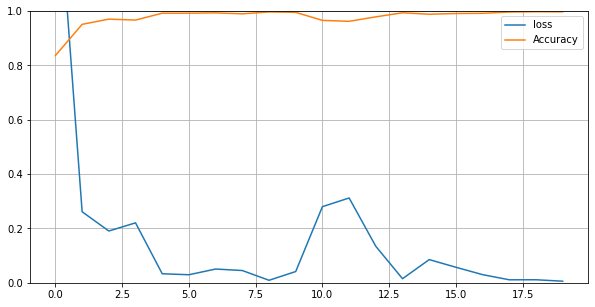

In [ ]:
plt.rcParams['figure.figsize']=(10,5)
pd.DataFrame(hist.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
Model.evaluate(test_generator)

21/21 [==============================] - 3s 140ms/step - loss: 0.2607 - Accuracy: 0.9723


[0.2607201039791107, 0.9722650051116943]

In [ ]:
Model.save('/content/drive/MyDrive/DataSets/Acute Leukemia Cancer Data/Residual_Architecture.h5')

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
dense_1=keras.layers.Dense(128,activation='relu')(keras.layers.Flatten()(Resnet_Architecture.output))
dense_2=keras.layers.Dense(64,activation='relu')(dense_1)
output=keras.layers.Dense(4,activation='softmax')(dense_1)
Model_2=keras.models.Model([Resnet_Architecture.input],[output])

Model_2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                     loss='sparse_categorical_crossentropy',
                     metrics=['Accuracy'])
hist=Model_2.fit(train_generator,epochs=10)

Epoch 1/10
82/82 [==============================] - 34s 231ms/step - loss: 0.7516 - Accuracy: 0.8964
Epoch 2/10
82/82 [==============================] - 21s 261ms/step - loss: 0.1572 - Accuracy: 0.9705
Epoch 3/10
82/82 [==============================] - 19s 227ms/step - loss: 0.0693 - Accuracy: 0.9804
Epoch 4/10
82/82 [==============================] - 19s 232ms/step - loss: 0.0606 - Accuracy: 0.9816
Epoch 5/10
82/82 [==============================] - 19s 232ms/step - loss: 0.0398 - Accuracy: 0.9881
Epoch 6/10
82/82 [==============================] - 19s 237ms/step - loss: 0.0240 - Accuracy: 0.9904
Epoch 7/10
82/82 [==============================] - 20s 243ms/step - loss: 0.0361 - Accuracy: 0.9908
Epoch 8/10
82/82 [==============================] - 19s 226ms/step - loss: 0.0291 - Accuracy: 0.9927
Epoch 9/10
82/82 [==============================] - 19s 229ms/step - loss: 0.0135 - Accuracy: 0.9962
Epoch 10/10
82/82 [==============================] - 19s 230ms/step - loss: 0.0190 - Accura

In [ ]:
Model_2.evaluate(test_generator)

21/21 [==============================] - 4s 102ms/step - loss: 0.6732 - Accuracy: 0.8213


[0.6732013821601868, 0.8212634921073914]

## Multi Output Resnet

In [ ]:
datagen_cat = ImageDataGenerator(rescale=1/255.0,validation_split=0.2) 

train_generator_cat = datagen.flow_from_directory(
    '/content/drive/MyDrive/DataSets/Acute Leukemia Cancer Data/Original',
    target_size=(128, 128),
    class_mode='categorical',
    subset='training',
    batch_size=2607,
    shuffle=True) 

test_generator_cat = datagen.flow_from_directory(
    '/content/drive/MyDrive/DataSets/Acute Leukemia Cancer Data/Original', 
    target_size=(128, 128),
    class_mode='categorical',
    subset='validation',
    batch_size=2607,
    shuffle=True)

Found 2607 images belonging to 4 classes.
Found 649 images belonging to 4 classes.


In [ ]:
dense_1=keras.layers.Dense(128,activation='relu')(keras.layers.Flatten()(Resnet_Architecture.output))
output_1=keras.layers.Dense(1,activation='sigmoid')(dense_1)
output_2=keras.layers.Dense(1,activation='sigmoid')(dense_1)
output_3=keras.layers.Dense(1,activation='sigmoid')(dense_1)
output_4=keras.layers.Dense(1,activation='sigmoid')(dense_1)
Model_3=keras.models.Model([Resnet_Architecture.input],[output_1,output_2,output_3,output_4])

Model_3.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                     loss='binary_crossentropy',
                     metrics=['Accuracy'])
hist=Model_3.fit(train_generator_cat,epochs=50)

## Auto Encoder Based Architecture

In [ ]:
Encoder=keras.models.Sequential([
      keras.layers.Input(shape=(128,128,3)),
      keras.layers.Conv2D(16,(3,3),padding='same' ),
      keras.layers.MaxPooling2D((2,2)),
      keras.layers.Conv2D(8,(3,3),padding='same' ),
      keras.layers.MaxPooling2D((2,2)),
      # keras.layers.Conv2D(4,(3,3),padding='same'),
      keras.layers.Flatten(),
      keras.layers.Dense(512,activation='relu'),
      keras.layers.Dense(256,activation='relu'),
      keras.layers.Dense(128,activation='relu'),
      keras.layers.Dense(64,activation='relu'),
      keras.layers.Dense(2)
])
Decoder=keras.models.Sequential([
  keras.layers.Input(shape=[2]),
  keras.layers.Dense(128,activation='selu'),
  keras.layers.Reshape((4,4,8)),
  keras.layers.Conv2DTranspose(32,(3,3)),
  keras.layers.Conv2DTranspose(16,(3,3)),
  keras.layers.UpSampling2D(),
  keras.layers.Conv2DTranspose(16,(3,3)),
  keras.layers.Conv2DTranspose(3,(3,3)),
  keras.layers.Conv2DTranspose(16,(3,3)),
  keras.layers.Conv2DTranspose(3,(3,3)),
  keras.layers.UpSampling2D(),
  keras.layers.Conv2DTranspose(16,(3,3)),
  keras.layers.Conv2DTranspose(3,(3,3)),
  keras.layers.Conv2DTranspose(16,(3,3)),
  keras.layers.Conv2DTranspose(3,(3,3)),
  keras.layers.Conv2DTranspose(16,(3,3)),
  keras.layers.Conv2DTranspose(3,(3,3)),
  keras.layers.Conv2DTranspose(16,(3,3)),
  keras.layers.Conv2DTranspose(3,(3,3)),
  keras.layers.UpSampling2D()
])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


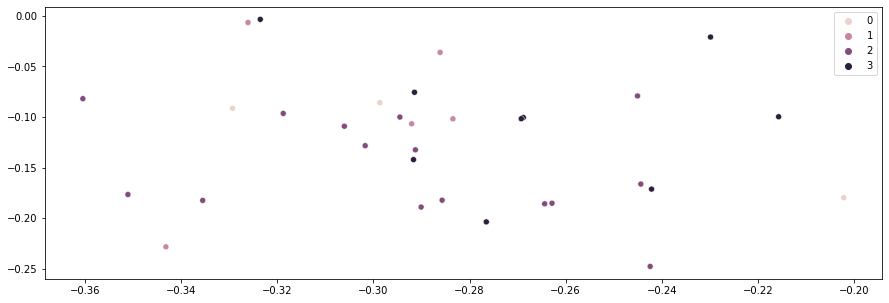

In [ ]:
import seaborn as sns
plt.rcParams['figure.figsize']=(15,5)
encoded=Encoder(next(train_generator)[0]).numpy()
class_names=np.array([0,1,2,3])
sns.scatterplot(encoded[:,0],encoded[:,1],hue=class_names[np.array((next(train_generator)[1]),dtype=np.int)])
plt.show()